##### Copyright 2022 The TensorFlow GNN Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Molecular Graph Classification with TF-GNN

<table class="tfo-notebook-buttons" align="left">
  <td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/gnn/blob/master/examples/notebooks/intro_mutag_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/gnn/blob/main/examples/notebooks/intro_mutag_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
</table>

We will demonstrate how to do graph classification with TF-GNN.

For this example, we will do molecular property prediction, where each molecule is represented as a graph. Nodes correspond to atoms, and edges represent the bonds between them. This is one of the application areas where GNNs are now the method of choice.

We will use the MUTAG dataset, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

There are 188 graphs in this dataset, labeled with one of two classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features  represent the bond type using a 1-hot encoding (0=aromatic,1=single, 2=double, 3=triple).

Please note that this is an introductory example on homogeneous graphs (one node type, and one edge type). TF-GNN is designed to support heterogeneous graphs as well (multiple node types, and/or multiple edge types).

## Imports

Before Python can `import tensorflow_gnn`, the PIP package [`tensorflow-gnn`](https://pypi.org/project/tensorflow-gnn/) needs to be downloaded and installed.

In [ ]:
!pip install --pre -q tensorflow-gnn

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn
from tensorflow_gnn.models import gcn
from tensorflow_gnn.models import graph_sage
from google.protobuf import text_format
import tensorflow_gnn.proto.graph_schema_pb2 as schema_pb2

print(f'Running TF-GNN {tfgnn.__version__} with TensorFlow {tf.__version__}.')

### Download the MUTAG dataset
We have created a version of the MUTAG Dataset in TF-GNN's file format to use as an example in this colab.

Citation: [Morris, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663. 2020.](https://chrsmrrs.github.io/datasets/)

In [ ]:
# Download and unzip dataset.
!wget https://storage.googleapis.com/download.tensorflow.org/data/mutag.zip
!unzip mutag.zip

In [ ]:
train_path = os.path.join(os.getcwd(), 'mutag', 'train.tfrecords')
val_path = os.path.join(os.getcwd(), 'mutag', 'val.tfrecords')
!ls -l {train_path} {val_path}

### Generate GraphTensor

Declare the GraphSchema protocol message which describes the entity and relation types, as well as their respective features. Here's a depiction of the graph schema for the mutag dataset:

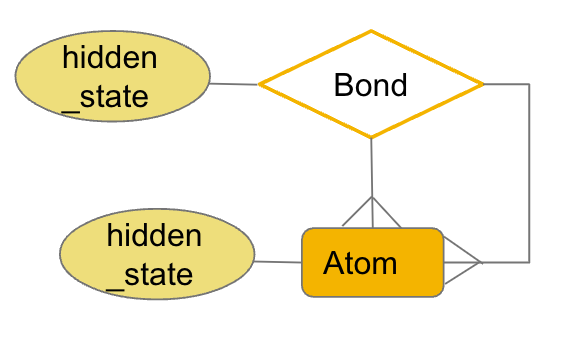


Calling [tfgnn.create_graph_spec_from_schema_pb](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/api_docs/python/tfgnn/create_graph_spec_from_schema_pb.md) with the GraphSchema will provide us the GraphTensorSpec. GraphTensorSpec can be used to parse serialized tf.Example protos into the GraphTensor using [tfgnn.parse_single_example](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/api_docs/python/tfgnn/parse_single_example.md) api with the tf.data.dataset's map function.

In [ ]:
# @title Declare GraphSchema { vertical-output: true }
schema_pbtx = """
# proto-file: //third_party/py/tensorflow_gnn/proto/graph_schema.proto
# proto-message: tensorflow_gnn.GraphSchema
context {
  features {
    key: "label"
    value: {
      description: "compound mutagenicity."
      dtype: DT_INT32
    }
  }
}
node_sets {
  key: "atoms"
  value {
    features {
      key: "hidden_state"
      value {
        description: "atom type."
        dtype: DT_FLOAT
        shape { dim { size: 7 } }
      }
    }
  }
}
edge_sets {
  key: "bonds"
  value {
    source: "atoms"
    target: "atoms"
    features {
      key: "hidden_state"
      value {
        description: "bond type."
        dtype: DT_FLOAT
        shape { dim { size: 4 } }
      }
    }
  }
}
"""
graph_schema = text_format.Merge(schema_pbtx, schema_pb2.GraphSchema())
print(f"graph_schema: {graph_schema}")
graph_tensor_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)
def decode_fn(record_bytes):  
  graph = tfgnn.parse_single_example(
      graph_tensor_spec, record_bytes, validate=True)

  # extract label from context and remove from input graph
  context_features = graph.context.get_features_dict()
  label = context_features.pop('label')
  new_graph = graph.replace_features(context=context_features)

  return new_graph, label

In [ ]:
#@title Read Datasets
train_ds = tf.data.TFRecordDataset([train_path]).map(decode_fn)
val_ds = tf.data.TFRecordDataset([val_path]).map(decode_fn)

### Look at one example from the dataset

In [ ]:
g, y = train_ds.take(1).get_single_element()

#### Node features

Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F,
4=I, 5=Cl, 6=Br).

In [ ]:
print(g.node_sets['atoms'].features[tfgnn.HIDDEN_STATE])

In [ ]:
g.node_sets['atoms']

#### Bond Edges

In this example, we consider the bonds between atoms as undirected edges. To encode them in the GraphTensor, we store the undirected edges as pairs of directed edges in both directions.

`adjacency.source` contains the source node indices, and `adjacency.target` contains the corresponding target node indices.

In [ ]:
g.edge_sets['bonds'].adjacency.source

In [ ]:
g.edge_sets['bonds'].adjacency.target

#### Edge features

Edge features represent the bond type as one-hot encoding (0=aromatic,1=single,
2=double, 3=triple).

In [ ]:
g.edge_sets['bonds'][tfgnn.HIDDEN_STATE]

#### Context

Context can be used to store graph-level information

In [ ]:
g.context

### Label
The label is binary, indicating the mutagenicity of the molecule. It's either 0 or 1.

In [ ]:
y

#### Batch the datasets

In [ ]:
batch_size = 32 #@param {type:"integer"}

train_ds_batched = train_ds.batch(batch_size=batch_size).repeat()
val_ds_batched = val_ds.batch(batch_size=batch_size)

### Build the GNN model

TF-GNN provides Keras layers for building graph neural networks. The following code uses Keras' [Functional API](https://www.tensorflow.org/guide/keras/functional) to build a model as a series of GraphTensor transformations, followed by reading out a plain Tensor with the final prediction.

Feel free to play with the hyperparameters and the model architecture to improve the results!


In [ ]:
# @title GNN Model { vertical-output: true }

graph_convolution_type = "graph_sage" #@param ["default", "gcn", "graph_sage"] 
learning_rate = 1e-3 #@param {type:"number"}
steps_per_epoch = 10 #@param {type:"integer"}
epochs = 200 #@param {type:"integer"}
learning_rate_decay = True #@param {type:"boolean"}
node_dim = 16 #@param {type:"integer"}
edge_dim = 16 #@param {type:"integer"}

if learning_rate_decay:
  learning_rate = tf.keras.optimizers.schedules.CosineDecay(learning_rate, steps_per_epoch*epochs)

def _build_model(
    graph_tensor_spec,
    # Dimensions of initial states.
    node_dim=16,
    edge_dim=16,
    context_dim=16,
    # Dimensions for message passing.
    message_dim=64,
    next_state_dim=64,
    # Dimension for the logits.
    num_classes=2,
    # Number of message passing steps.
    num_message_passing=3,
    # Other hyperparameters.
    l2_regularization=5e-4,
    dropout_rate=0.5,
):
  # Model building with Keras's Functional API starts with an input object
  # (a placeholder for the eventual inputs). Here is how it works for
  # GraphTensors:
  input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)

  # IMPORTANT: All TF-GNN modeling code assumes a GraphTensor of shape []
  # in which the graphs of the input batch have been merged to components of
  # one contiguously indexed graph. (There are no edges between components,
  # so no information flows between them.)
  graph = input_graph.merge_batch_to_components()

  # Nodes and edges have one-hot encoded input features. Sending them through
  # a Dense layer effectively does a lookup in a trainable embedding table.
  def set_initial_node_state(node_set, *, node_set_name):
    # Since we only have one node set, we can ignore node_set_name.
    return tf.keras.layers.Dense(node_dim)(node_set[tfgnn.HIDDEN_STATE])
  def set_initial_edge_state(edge_set, *, edge_set_name):
    if graph_convolution_type != "default":
      return {}
    return tf.keras.layers.Dense(edge_dim)(edge_set[tfgnn.HIDDEN_STATE])

  # MapFeatures layer receives callbacks as input for each graph piece: node_set
  # edge_set and context. Each callback applies a transformation over the 
  # existing features of the respective graph piece while using a Keras
  # Functional API to call new Keras Layers. For more information and examples 
  # about the MapFeatures layer please check out its docstring. This call here 
  # initializes the hidden states of the edge and node sets. 
  graph = tfgnn.keras.layers.MapFeatures(
      node_sets_fn=set_initial_node_state, edge_sets_fn=set_initial_edge_state)(
          graph)
      
  num_atoms = tf.expand_dims(tf.cast(graph.node_sets["atoms"].sizes, dtype=tf.float32), axis=-1)
  num_bonds = tf.expand_dims(tf.cast(graph.edge_sets["bonds"].sizes, dtype=tf.float32), axis=-1)
  graph = graph.replace_features(
      context={
          tfgnn.HIDDEN_STATE: tf.concat([num_atoms, num_bonds], axis=1)
          })
 
  # This helper function is just a short-hand for the code below.
  def dense(units, activation="relu"):
    """A Dense layer with regularization (L2 and Dropout)."""
    regularizer = tf.keras.regularizers.l2(l2_regularization)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate)
    ])

  # The GNN core of the model does `num_message_passing` many updates of node
  # states conditioned on their neighbors and the edges connecting to them.
  # More precisely:
  #  - Each edge computes a message by applying a dense layer `message_fn`
  #    to the concatenation of node states of both endpoints (by default)
  #    and the edge's own unchanging feature embedding.
  #  - Messages are summed up at the common TARGET nodes of edges.
  #  - At each node, a dense layer is applied to the concatenation of the old
  #    node state with the summed edge inputs to compute the new node state.
  # Each iteration of the for-loop creates new Keras Layer objects, so each
  # round of updates gets its own trainable variables.
  for i in range(num_message_passing):
    if graph_convolution_type == "default":
      graph = tfgnn.keras.layers.GraphUpdate(
          node_sets={
              "atoms": tfgnn.keras.layers.NodeSetUpdate(
                  {"bonds": tfgnn.keras.layers.SimpleConv(
                       sender_edge_feature=tfgnn.HIDDEN_STATE,
                       message_fn=dense(message_dim),
                       reduce_type="sum",
                       receiver_tag=tfgnn.TARGET)},
                  tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim)))},
      )(graph)
    elif graph_convolution_type == "gcn":
      graph = gcn.GCNHomGraphUpdate(
          units= message_dim,
          name= graph_convolution_type +"_layer_" + str(i))(graph)
    elif graph_convolution_type == "graph_sage":
      graph = graph_sage.GraphSAGEGraphUpdate(
        node_set_names=["atoms"],
        receiver_tag=tfgnn.TARGET,
        reduce_type="sum",
        use_pooling=True,
        use_bias=False,
        dropout_rate=dropout_rate,
        units=message_dim,
        hidden_units=message_dim * 2,
        l2_normalize=True,
        combine_type="sum",
        activation="relu",
        name="gsage_layer_" + str(i))(graph)

  # After the GNN has computed a context-aware representation of the "atoms",
  # the model reads out a representation for the graph as a whole by averaging
  # (pooling) node states into the graph context. The context is global to each
  # input graph of the batch, so the first dimension of the result corresponds
  # to the batch dimension of the inputs (same as the labels).
  readout_features = tfgnn.keras.layers.Pool(
      tfgnn.CONTEXT, "mean", node_set_name="atoms")(graph)
  # Context  has a hidden-state feature, concatenate the aggregated node vectors
  # with the hidden-state to get the final vector,
  feat = tf.concat([readout_features, graph.context[tfgnn.HIDDEN_STATE]], axis=1)
  # Put a linear classifier on top (not followed by dropout).
  logits = tf.keras.layers.Dense(1)(feat)

  # Build a Keras Model for the transformation from input_graph to logits.
  return tf.keras.Model(inputs=[input_graph], outputs=[logits])

#### Define Loss and Metrics

In [ ]:
model_input_graph_spec, label_spec = train_ds.element_spec
del label_spec # Unused.
model = _build_model(model_input_graph_spec)

In [ ]:
train_ds.element_spec

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.),
            tf.keras.metrics.BinaryCrossentropy(from_logits=True)]

#### Compile the keras model

In [ ]:
# @title Optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer, loss=loss, metrics=metrics)
model.summary()

#### Train the model

In [ ]:
history = model.fit(train_ds_batched,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_ds_batched)

### Plot the loss and metric curves for train and val

In [ ]:
for k, hist in history.history.items():
  plt.plot(hist)
  plt.title(k)
  plt.show()

## GraphTensor Advanced

### Batch of GraphTensors:

In [ ]:
batch_size = 5 #@param {type:"integer"}

gt, y = train_ds.batch(batch_size).take(1).get_single_element()
gt

In [ ]:
gt.node_sets["atoms"][tfgnn.HIDDEN_STATE]

In [ ]:
gt.edge_sets["bonds"].adjacency.source

### Merged Scalar GraphTensor

In [ ]:
scalar_gt = g.merge_batch_to_components()
scalar_gt

In [ ]:
scalar_gt.node_sets["atoms"][tfgnn.HIDDEN_STATE]

In [ ]:
gt.edge_sets["bonds"].adjacency.source

## Heterogeneos Graph Convolutions

In the following subsections you can see a snippet call from GraphUpdate call over the **M**icrosoft **A**cademic **G**raph ([ogb-mag](https://ogb.stanford.edu/)) dataset with the depicted schema below.  Checkout this [colab](https://colab.sandbox.google.com/github/tensorflow/gnn/blob/master/examples/notebooks/ogbn_mag_e2e.ipynb#scrollTo=b7fhATRUexKh) for the full example.

 

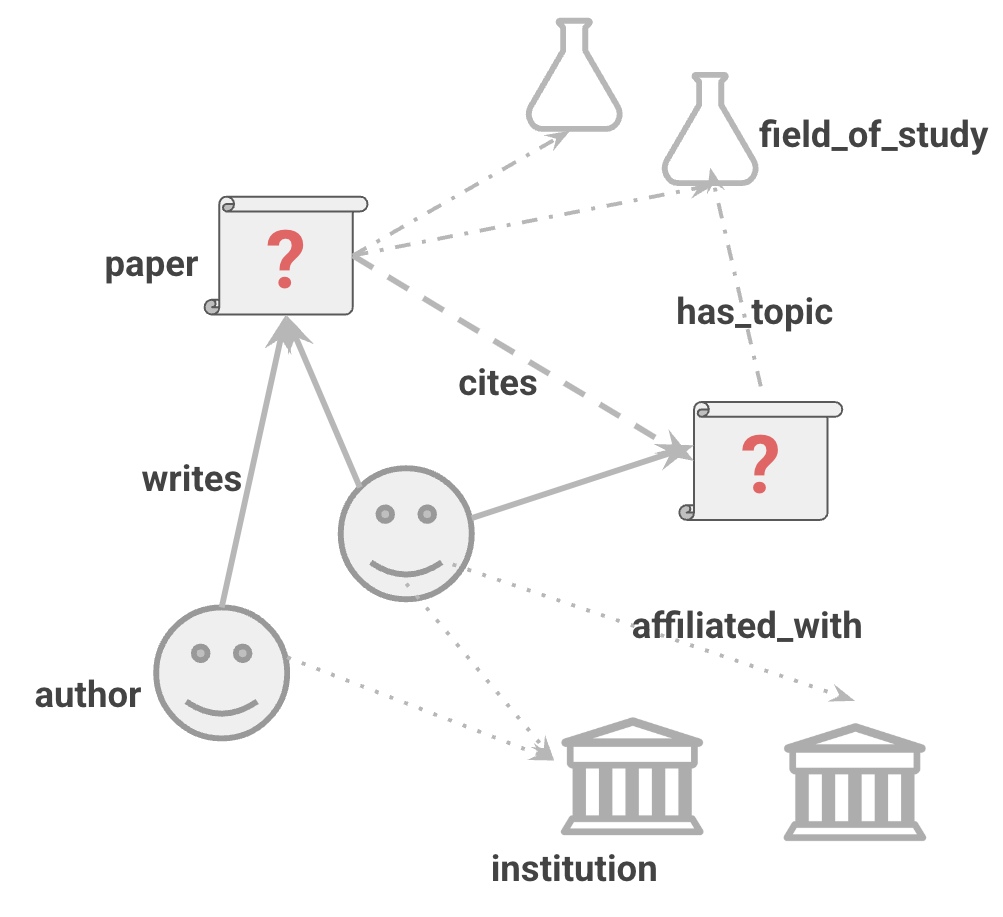

## GraphUpdate for Heterogeneous Graphs

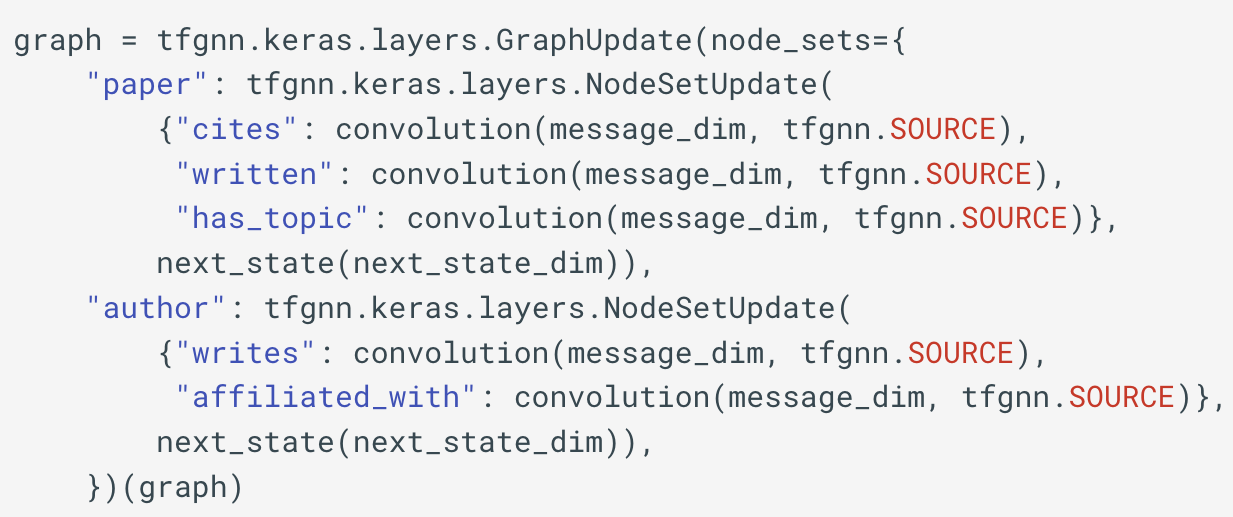